In [18]:
import csv
import pandas as pd
from collections import defaultdict
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
output_lift_values = 'Lift_Values.csv'
output_lift_matrix = 'Lift_Matrix.csv'
input_file = 'replaced_data.csv'  # Corrected to your file

def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                # Ignore lines with errors (invalid format)
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts

def calculate_lift_for_brands(posts, top_brands):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        for word in unique_words:
            if word in top_brands:
                word_frequency[word] += 1
        for word1 in unique_words:
            for word2 in unique_words:
                if word1 != word2 and word1 in top_brands and word2 in top_brands:
                    word_pair_frequency[word1][word2] += 1

    df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])
    for word1 in top_brands:
        for word2 in top_brands:
            if word1 != word2:
                p_word1_and_word2 = word_pair_frequency[word1][word2] / total_posts
                p_word1 = word_frequency[word1] / total_posts
                p_word2 = word_frequency[word2] / total_posts
                if p_word1 > 0 and p_word2 > 0:
                    lift_value = p_word1_and_word2 / (p_word1 * p_word2)
                    df_lift = df_lift.append({'word1': word1, 'word2': word2, 'lift_value': lift_value}, ignore_index=True)

    # Format and print the lift matrix nicely
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0 for display

    print("\nFormatted Lift Matrix:\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift

def save_results(df_lift):
    df_lift.to_csv(output_lift_values, index=False)
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix.to_csv(output_lift_matrix)

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
df_lift = calculate_lift_for_brands(posts, top_brands)
save_results(df_lift)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramzikattan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


AttributeError: 'DataFrame' object has no attribute 'append'

In [19]:
import csv
import pandas as pd
from collections import defaultdict
import re
import string
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# File paths
wordcounts_file = 'brand_counts.csv'
replacement_words_file = 'merged-1.csv'
output_lift_values = 'Lift_Values.csv'
output_lift_matrix = 'Lift_Matrix.csv'
input_file = 'replaced_data.csv'

def clean_text(text):
    # Remove punctuation, convert to lowercase, and remove stopwords
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    return [word for word in text.split() if word not in stop_words]

def load_word_counts(filename):
    word_counts = {}
    with open(filename, 'r') as file:
        for line in file:
            try:
                word, count = line.strip().split(',')
                word_counts[word] = int(count)
            except ValueError:
                continue
    return dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))

def load_replacement_words(filename):
    df = pd.read_csv(filename)
    valid_brands = set(df['make'].unique())
    valid_brands -= {'car', 'seat', 'problem', 'sedan'}  # Exclude unwanted words
    return valid_brands

def get_top_brands(word_counts, valid_brands):
    top_brands = [word for word in word_counts if word in valid_brands]
    return top_brands[:10]  # Limit to 10 brands

def process_input_file(input_filename):
    posts = []
    with open(input_filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            post = clean_text(row[1])  # Assuming post text is in the second column
            posts.append(post)
    return posts

#def calculate_lift_for_brands(posts, top_brands, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post

        # Record positions of the top brands in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance
        for brand1 in top_brands:
            for brand2 in top_brands:
                if brand1 != brand2 and brand_positions[brand1] and brand_positions[brand2]:
                    # Check if any pair of positions is within max_distance
                    for pos1 in brand_positions[brand1]:
                        for pos2 in brand_positions[brand2]:
                            if abs(pos1 - pos2) <= max_distance:
                                word_pair_frequency[brand1][brand2] += 1
                                break  # Only count once per post

    # Calculate lift values
    lift_values = []
    for word1 in top_brands:
        for word2 in top_brands:
            if word1 != word2:
                p_word1_and_word2 = word_pair_frequency[word1][word2] / total_posts
                p_word1 = word_frequency[word1] / total_posts
                p_word2 = word_frequency[word2] / total_posts
                if p_word1 > 0 and p_word2 > 0:
                    lift_value = p_word1_and_word2 / (p_word1 * p_word2)
                    lift_values.append({'word1': word1, 'word2': word2, 'lift_value': lift_value})

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
   # lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    #lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    #print("\nFormatted Lift Matrix:\n")
    #print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift

import itertools
import pandas as pd
from collections import defaultdict

def calculate_lift_for_brands(posts, top_brands, max_distance=5):
    word_frequency = defaultdict(int)
    word_pair_frequency = defaultdict(lambda: defaultdict(int))
    total_posts = len(posts)

    # Count brand frequencies and co-occurrences
    for post in posts:
        unique_words = set(post)
        brand_positions = {brand: [] for brand in top_brands}  # Track positions of top brands in the post

        # Record positions of the top brands in the post
        for index, word in enumerate(post):
            if word in top_brands:
                brand_positions[word].append(index)

        # Count brand frequencies (mention once per post, even if it appears multiple times)
        for brand in brand_positions:
            if brand_positions[brand]:  # If the brand appeared in the post
                word_frequency[brand] += 1

        # Check for co-occurrences within the max_distance
        for brand1, brand2 in itertools.combinations(top_brands, 2):
            if brand_positions[brand1] and brand_positions[brand2]:
                # Check if any pair of positions is within max_distance
                for pos1 in brand_positions[brand1]:
                    for pos2 in brand_positions[brand2]:
                        if abs(pos1 - pos2) <= max_distance:
                            word_pair_frequency[brand1][brand2] += 1
                            word_pair_frequency[brand2][brand1] += 1  # Ensure both directions are updated
                            break  # Only count once per post

    # Calculate lift values
    lift_values = []
    for brand1, brand2 in itertools.combinations(top_brands, 2):
        p_word1_and_word2 = word_pair_frequency[brand1][brand2] / total_posts
        p_word1 = word_frequency[brand1] / total_posts
        p_word2 = word_frequency[brand2] / total_posts
        if p_word1 > 0 and p_word2 > 0:
            lift_value = p_word1_and_word2 / (p_word1 * p_word2)
            lift_values.append({'word1': brand1, 'word2': brand2, 'lift_value': lift_value})
            lift_values.append({'word1': brand2, 'word2': brand1, 'lift_value': lift_value})  # Symmetric value

    # Convert to DataFrame
    df_lift = pd.DataFrame(lift_values)

    # Format and print the lift matrix
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0

    print("\nFormatted Lift Matrix:\n")
    print(lift_matrix.to_string())  # Print matrix in a formatted chart style

    return df_lift


def save_results(df_lift):
    df_lift.to_csv(output_lift_values, index=False)
    lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')
    lift_matrix.to_csv(output_lift_matrix)

# Main script
word_counts = load_word_counts(wordcounts_file)
valid_brands = load_replacement_words(replacement_words_file)
top_brands = get_top_brands(word_counts, valid_brands)
posts = process_input_file(input_file)
df_lift = calculate_lift_for_brands(posts, top_brands)
save_results(df_lift)

top_brands

print(len(posts))

print(df_lift)

lift_matrix = df_lift.pivot(index='word1', columns='word2', values='lift_value')

lift_matrix = lift_matrix.combine_first(lift_matrix.T)

lift_matrix = lift_matrix.fillna(0)  # Fill missing values with 0


print(lift_matrix)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramzikattan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Formatted Lift Matrix:

word2        acura      audi       bmw  cadillac     honda  infiniti     lexus    nissan  polestar    toyota
word1                                                                                                       
acura     0.000000  1.305416  0.691702  0.777237  1.555565  1.474570  1.298838  0.626996  0.464038  0.448055
audi      1.305416  0.000000  1.050984  1.281457  0.352790  1.131131  0.972045  0.302316  0.573422  0.224631
bmw       0.691702  1.050984  0.000000  0.881988  0.352385  1.218241  1.228950  0.273750  0.561806  0.378621
cadillac  0.777237  1.281457  0.881988  0.000000  0.244809  1.061159  1.191893  0.166168  0.314284  0.230475
honda     1.555565  0.352790  0.352385  0.244809  0.000000  0.722378  0.667641  1.542792  0.538704  2.337375
infiniti  1.474570  1.131131  1.218241  1.061159  0.722378  0.000000  1.215312  1.146625  0.681411  0.585008
lexus     1.298838  0.972045  1.228950  1.191893  0.667641  1.215312  0.000000  0.804066  0.541481  0.8

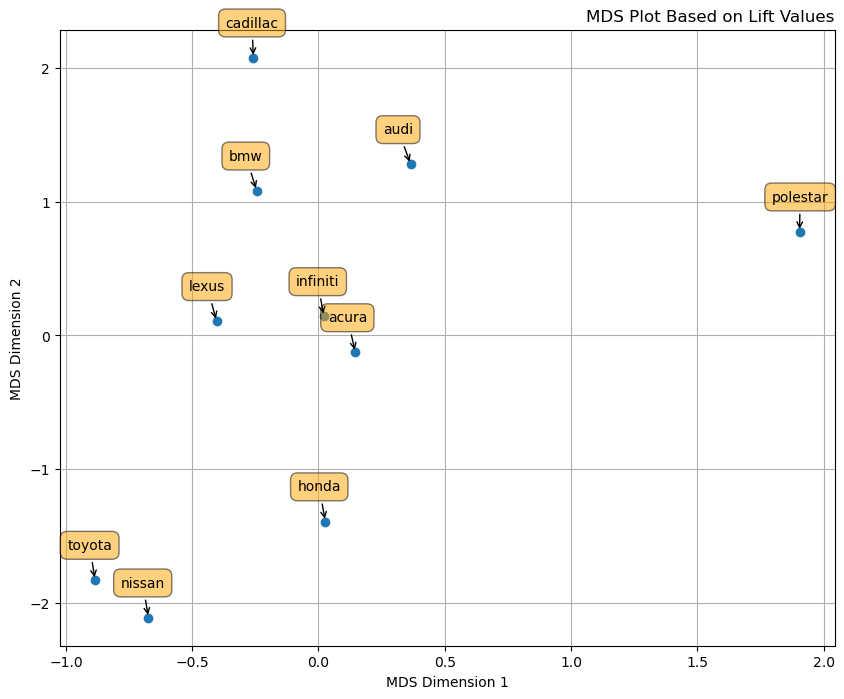

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

# Ensure `df_lift` is available and contains the lift values

# Invert the lift values to treat higher values as closer (distance)
# Use a small constant to avoid division by zero errors
dissimilarity_matrix = 1 / (lift_matrix + 1e-10)
np.fill_diagonal(dissimilarity_matrix.values, 0)  # Set diagonal to zero

# Multidimensional Scaling (MDS)
seed = np.random.RandomState(seed=3)
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, 
                   random_state=seed, dissimilarity="precomputed")

try:
    results = mds.fit(dissimilarity_matrix)
    coords = results.embedding_
    
except ValueError as e:
    print(f"Error during MDS fitting: {e}")
    coords = np.zeros((len(lift_matrix), 2))  # Placeholder in case of error

# Plotting the MDS results
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], marker='o')

# Annotate each point with the corresponding brand name
for label, x, y in zip(lift_matrix.index, coords[:, 0], coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-20, 20),
                 textcoords='offset points', ha='left', va='bottom',
                 bbox=dict(boxstyle='round,pad=0.5', fc='orange', alpha=0.5),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Left-align the title
plt.title('MDS Plot Based on Lift Values', loc='right')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()


In [3]:
# Takeaways

- Volkswagen is a middle brand between beginner and entry level luxury cars
- Audi is talked about more with VW than any other brand
- Luxury brands are distinct while entry level are not

In viewing the MDS plot there arae two major clumps. The first is the more casual brands of VW, Nissan, Honda, then there are the luxury brands. These cluster indicate people see the luxury cars as different from the more entry level vehicles. Secondly, Volkswagen owners would be the best to target for shifting to a luxury brand. Volkswagon had the strongest lift with Audi while also having strong lifts with Nissian and Honda. In essence, Volkswagen could be considered a middle man brand between entry level and entry luxury based on the data.

Audi is another interesting brand since it's strongest lift happens to be between VW, but everything else is close to 1. People talk about Audi and VW more than Audi and other luxury brands. Therefore, Audi as a brand should use maarketing spend on VW users. 

Lastly, the luxury brands do not have as strong as a lift as the "more basic" brands do. It wold indiciate that there is a lack of people using luxury brands in the same post. The lack of lift could indicate that the people posting see the luxury brands as more distinct and in less need of comparison vs the entry level vehical brands. 

SyntaxError: invalid syntax (178385677.py, line 3)